# Jupyter Notebook

## Prerequisites

AIMBAT can run in a Jupyter Notebook. However, as AIMBAT uses interactive GUI elements, we must specify
that we want those to open inside the notebook rather than independant windows. For matplotlib this is
done by using the Ipython magic command :

In [1]:
%matplotlib widget

## Environment Setup

For this example project we create a temporary directory to store seismogram data, and a temporary file to store the aimbat project.

In [2]:
import tempfile
import os

example_project = tempfile.mktemp(prefix="aimbat_project_", suffix=".db")
sampledata_directory = tempfile.mkdtemp(prefix="aimbat_sample_data_")
os.environ["AIMBAT_PROJECT"] = example_project
os.environ["AIMBAT_SAMPLEDATA_DIR"] = sampledata_directory

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
        By default, all AIMBAT commands assume the project a file called "aimbat.db" in the current directory. Here we override that behavior by settings
    </p>
</div>

## Create a new Project

In [3]:
from aimbat.lib.project import create_project, delete_project

In [4]:
create_project()

Creating an AIMBAT project creates a new sqlite file to store filepaths and processing data in. This also includes some defaults (which can be set on a per project basis too). To use this sqlite database we import the "engine" that points towards it:

In [5]:
from aimbat.lib.db import engine

In [6]:
from aimbat.lib.utils.sampledata import download_sampledata, delete_sampledata
from glob import glob

download_sampledata()
sacfiles = glob(sampledata_directory + "/**/*.BHZ", recursive=True)
print(f"Downloaded {len(sacfiles)} files")

Downloaded 163 files


In [7]:
from aimbat.lib.data import add_files_to_project
from aimbat.lib.io import DataType

add_files_to_project(sacfiles, DataType.SAC)

In [8]:
from aimbat.lib.seismogram import plot_seismograms
from aimbat.lib.models import AimbatEvent
from aimbat.lib.event import print_event_table, set_active_event

print_event_table()

                                                   AIMBAT Events                                                   
╭────────────────┬────────┬─────────────────────┬──────────┬───────────┬────────┬──────────┬───────────┬──────────╮
│                │        │                     │          │           │        │          │     #     │    #     │
│ id (shortened) │ Active │     Date & Time     │ Latitude │ Longitude │ Depth  │ Complet… │ Seismogr… │ Stations │
├────────────────┼────────┼─────────────────────┼──────────┼───────────┼────────┼──────────┼───────────┼──────────┤
│       c6       │        │ 2011-09-15 19:31:04 │ -21.611  │ -179.528  │ 644600 │  False   │    163    │   163    │
╰────────────────┴────────┴─────────────────────┴──────────┴───────────┴────────┴──────────┴───────────┴──────────╯

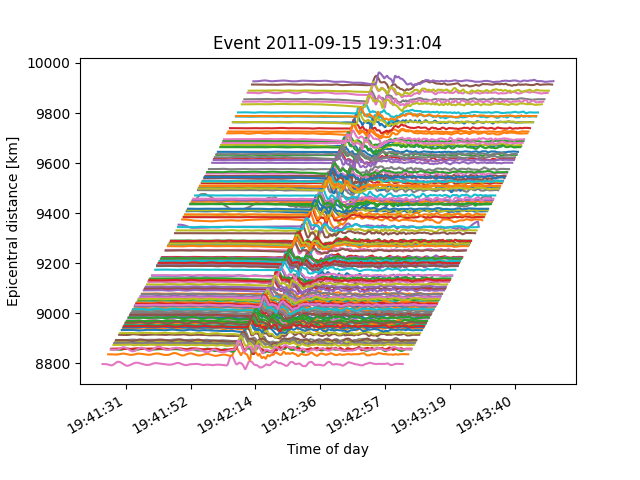

In [9]:
from sqlmodel import Session, select

with Session(engine) as session:
    set_active_event(session, session.exec(select(AimbatEvent)).one())
plot_seismograms()
delete_sampledata()

In [10]:
delete_project()